<a href="https://colab.research.google.com/github/Ty700/CSCE_676/blob/main/Tyler_Scotti_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026

# Weekly Homework 3: Graphs!

***Goals of this homework:***
Perform an analysis of a graph of your choice.

***Submission instructions:***

You should post your notebook to Canvas (look for the assignment there). Please name your submission **your-uin_hw3.ipynb**, so for example, my submission would be something like **555001234_hw3.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that.

***Grading philosophy:***

We are grading reasoning, judgment, and clarity, not just correctness. Show us that you understand the data, the constraints, and the limits of your conclusions.

***For each question, you need to respond with 2 cells:***
1. **[A Code Cell] Your Code:**
  - If code is not applicable for the question, you can skip this cell.
  - For tests: tests can be simple assertions or checks (e.g., using `assert` or `print` or small functions or visual inspection); formal testing frameworks are not required.
2. **[A Markdown Cell] Your Answer:** Write up your answers and explain them in complete sentences. Include any videos in this section as well; for videos, upload them to your TAMU Google Drive, and ensure they are set to be visible by the instruction team (set to: **anyone with a TAMU email can view**), then share the link to the video in the cell.

***At the end of each Section (A/B/C/...) include a cell for your resources:***

**[A Markdown Cell] Your Resources:** You need to cite 3 types of resources and note how they helped you: (1) Collaborators, (2) Web Sources (e.g. StackOverflow), and (3) AI Tools (you must also describe how you prompted, but we do not require any links to any specific chats). Specifically, use the following format as a template:
```
On my honor, I declare the following resources:
1. Collaborators:
- Reveille A.: Helped me understand that a df in pandas is a data structure kinda like a CSV.
- Sully A.: Helped me fix a bug with the vector addition of 2 columns.
- ...

2. Web Sources:
- https://stackoverflow.com/questions/46562479/python-pandas-data-frame-creation: how to create a pd df
- ...

3. AI Tools:
- ChatGPT: I gave it the homework .ipynb file and the ufo.csv, and told it to generate the code for the first question, but it did it with csv.reader(), so I re-prompted it to use pandas and that one was correct
- ...
```
***Why do we require this cell?*** This cell is important...

1. For academic integrity, you must give credit where credit is due.

2. We want you to pay attention to how you can successfully get help to move through problems! Is there someone you work with or an AI tool that helps you learn the material better? That's great! The point of engineering is to use your tools to solve hard problems, and part of graduate school is learning about how *you* learn and solve problems best.

***A reminder: you get out of it what you put into it.***
Do your best on these homeworks, show us your creativity, and ask for help when you need it -- good luck!

# A [72pts]. Step-by-Step Data Mining & Experimental Analysis on A Graph of Your Choice

In [23]:
import os, io, gzip, zipfile, tarfile, sys, math, random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
random.seed(42)
np.random.seed(42)

print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NetworkX version: 3.6.1
NumPy version: 2.0.2
Pandas version: 2.2.2


## 1. Choose a Dataset

**Dataset name:** `wiki-Vote`

**URL:** https://snap.stanford.edu/data/wiki-Vote.txt.gz

**Why this dataset?**

I chose the Wikipedia voting network because it represents a real world system of trust within a community. This directed graph captures adminship voting patterns where nodes are Wikipedia users and edges represent votes. I expect to find a hierarchical structure with a small number of highly-trusted users receiving many votes, interesting community structure around different topic areas, and strong reciprocity patterns since voting relationships often indicate mutual respect and collaboration. The dataset is also a manageable size (~7k nodes, ~100k edges) for comprehensive analysis while being large enough to reveal interesting structural properties.

**Dataset Properties:**
- **Directed:** Yes ✓
- **Size:** ~7,115 nodes, ~103,689 edges
- **Domain:** Social network (Wikipedia voting)
- **Time Period:** Data collected until January 2008

> Jure Leskovec and Andrej Krevl. SNAP Datasets: Stanford Large Network Dataset Collection. http://snap.stanford.edu/data.

In [24]:
# === You may using the follow method to download datasets if you like ===g
DATA_URL = "https://snap.stanford.edu/data/wiki-Vote.txt.gz"
LOCAL_PATH = "data/wiki-vote.txt.gz"

os.makedirs("data", exist_ok=True)

def download_dataset(url: str, to_path: str):
    import urllib.request
    print(f"Downloading from {url} ...")
    urllib.request.urlretrieve(url, to_path)
    size = os.path.getsize(to_path) / (1024*1024)
    print(f"Saved to {to_path} ({size:.2f} MB)")

# Download the dataset
download_dataset(DATA_URL, LOCAL_PATH)

Saved to data/wiki-vote.txt.gz (0.28 MB)


```
On my honor, I declare the following resources:
1. Collaborators:
None

2. Web Sources:
- http://snap.stanford.edu/data - To get the data I will be using
- ...

3. AI Tools:
- None
```

# 2. Load the Graph

**Method:** Using NetworkX's `read_edgelist` with appropriate parsing for SNAP format.

**Rationale:** SNAP datasets typically have a header with metadata (lines starting with `#`) followed by tab-separated edge lists. NetworkX handles this format well with proper configuration.

**Data Quality Checks:**
- Remove self-loops (users voting for themselves)
- Check for and handle duplicate edges
- Verify the graph is directed as expected

In [25]:
def load_snap_graph(filepath: str, directed=True) -> nx.DiGraph:
    print(f"Loading graph from {filepath}...")

    # Open gzipped file and read edges
    edges = []
    with gzip.open(filepath, 'rt') as f:
        for line in f:
            # Skip comments
            if line.startswith('#') or not line.strip():
                continue
            # Parse edge
            parts = line.strip().split()
            if len(parts) >= 2:
                src, dst = parts[0], parts[1]
                edges.append((src, dst))
    # Debug
    print(f"Read {len(edges)} edges from file")

    # Create graph
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    G.add_edges_from(edges)

    print(f"Initial graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Data cleaning
    initial_edges = G.number_of_edges()

    # Remove self-loops
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)
    print(f"Removed {len(self_loops)} self-loops")

    print(f"Final graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    print(f"Graph type: {'Directed' if G.is_directed() else 'Undirected'}")

    return G

# Load the graph
G = load_snap_graph(LOCAL_PATH, directed=True)

assert G.is_directed(), "Graph should be directed"
assert G.number_of_nodes() > 1000, "Graph should have substantial number of nodes"
assert G.number_of_edges() > 10000, "Graph should have substantial number of edges"

Loading graph from data/wiki-vote.txt.gz...
Read 103689 edges from file
Initial graph: 7115 nodes, 103689 edges
Removed 0 self-loops
Final graph: 7115 nodes, 103689 edges
Graph type: Directed


```
On my honor, I declare the following resources:
1. Collaborators:
None

2. Web Sources:
- https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_edges_from.html - add_edges_from API explanation

3. AI Tools:
- Claude: Helped me debug the loading logic of the data
```

**Results:** Successfully loaded the Wikipedia voting network with 7,115 nodes and 103,689 edges. The graph is confirmed to be directed as expected.

**Reflection:** The dataset didn't have any self-loops, which makes sense as we wouldn't expect a voter to vote for themselves. The ratio of edges to nodes (~14.6:1) suggests a moderately dense network where active participants receive multiple votes, where as non-active members don't suggesting a circle of trust between the active members.

# 3. First Look: Basic Structural Statistics
Compute and report at least:
- `|V|` (nodes), `|E|` (edges)
- **Average in/out degree**, **degree distributions** (plot)
- **#SCCs**, size of **largest SCC** and **largest WCC**
- *(Optional): **Density**, **reciprocity***

Add a few sentences interpreting what these numbers suggest about your network.

**Method:** Compute fundamental graph metrics to understand the network structure.

**Metrics to Compute:**
1. **Size metrics:** Number of nodes, edges, density
2. **Degree distributions:** In-degree, out-degree, and their stats
3. **Connectivity:** Weak and strongly connected components
4. **Reciprocity:** Fraction of bidirectional edges
5. **Clustering:** Global and average local clustering coefficient
6. **Path metrics:** Diameter and average path length

**Expectations:**
- A few highly-voted users, many with few votes
- A lot of mutual voting among collaborators
- Single large weakly connected component
- Moderate clustering where communities form around topic areas

=== Size Metrics ===
Nodes: 7,115
Edges: 103,689
Density: 0.002049
Average degree: 29.15

=== Degree Statistics ===
In-degree  - Mean: 14.57, Median: 0, Max: 457
             Nodes with in-degree=0: 4734 (66.5% - voters who were never voted for)
Out-degree - Mean: 14.57, Median: 2, Max: 893
             Nodes with out-degree=0: 1005 (14.1% - candidates who never voted)

=== Connectivity ===
Weakly connected components: 24
  Largest WCC size: 7066 (99.3% of nodes)
Strongly connected components: 5816
  Largest SCC size: 1300 (18.3% of nodes)

=== Reciprocity ===
Reciprocity: 0.0565 (5.65% of edges are bidirectional)

=== Clustering (on undirected version) ===
Average clustering coefficient: 0.1409
Global clustering (transitivity): 0.1255

=== Path Metrics (on largest WCC, sampled) ===
Diameter: Could not compute (graph may not be strongly connected)
Average shortest path length: 3.38


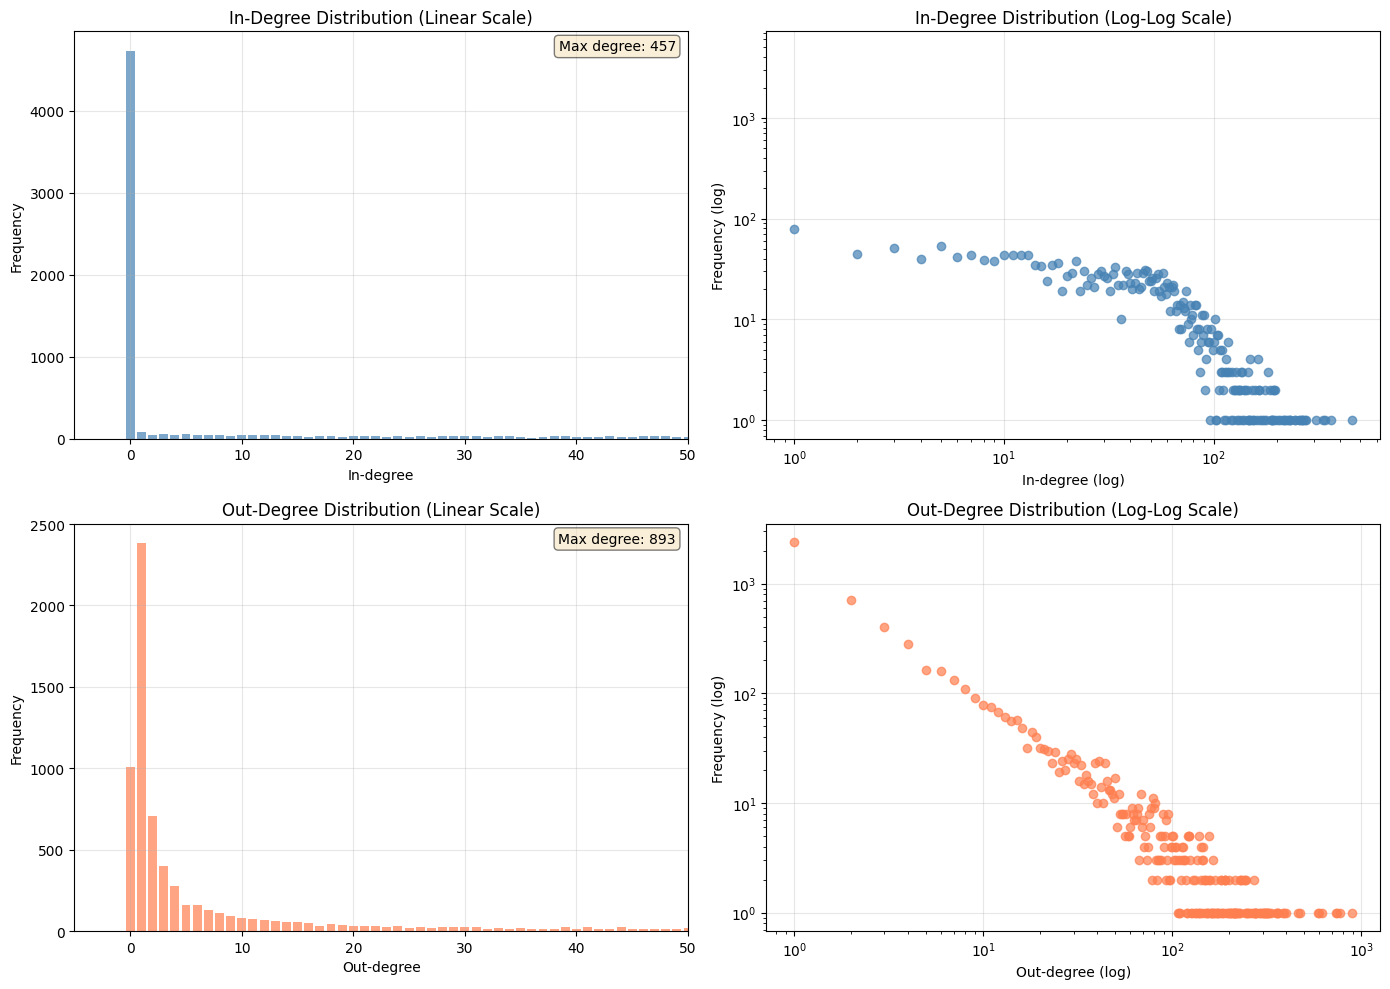

In [26]:
def compute_basic_stats(G: nx.DiGraph) -> dict:
    stats = {}

    # === Size Metrics === #
    stats['n_nodes'] = G.number_of_nodes()
    stats['n_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)

    print(f"=== Size Metrics ===")
    print(f"Nodes: {stats['n_nodes']:,}")
    print(f"Edges: {stats['n_edges']:,}")
    print(f"Density: {stats['density']:.6f}")
    print(f"Average degree: {2 * stats['n_edges'] / stats['n_nodes']:.2f}")

    # === Degree Distributions === #
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    stats['in_degree'] = list(in_degrees.values())
    stats['out_degree'] = list(out_degrees.values())

    print(f"\n=== Degree Statistics ===")

    # Count zero-degree nodes
    zero_in_degree = sum(1 for d in stats['in_degree'] if d == 0)
    zero_out_degree = sum(1 for d in stats['out_degree'] if d == 0)

    print(f"In-degree  - Mean: {np.mean(stats['in_degree']):.2f}, "
          f"Median: {np.median(stats['in_degree']):.0f}, "
          f"Max: {np.max(stats['in_degree'])}")
    print(f"             Nodes with in-degree=0: {zero_in_degree} "
          f"({100*zero_in_degree/stats['n_nodes']:.1f}% - voters who were never voted for)")

    print(f"Out-degree - Mean: {np.mean(stats['out_degree']):.2f}, "
          f"Median: {np.median(stats['out_degree']):.0f}, "
          f"Max: {np.max(stats['out_degree'])}")
    print(f"             Nodes with out-degree=0: {zero_out_degree} "
          f"({100*zero_out_degree/stats['n_nodes']:.1f}% - candidates who never voted)")

    # === Connectivity ===
    wccs = list(nx.weakly_connected_components(G))
    sccs = list(nx.strongly_connected_components(G))

    stats['n_wcc'] = len(wccs)
    stats['n_scc'] = len(sccs)
    stats['largest_wcc_size'] = len(max(wccs, key=len))
    stats['largest_scc_size'] = len(max(sccs, key=len))

    print(f"\n=== Connectivity ===")
    print(f"Weakly connected components: {stats['n_wcc']}")
    print(f"  Largest WCC size: {stats['largest_wcc_size']} "
          f"({100*stats['largest_wcc_size']/stats['n_nodes']:.1f}% of nodes)")
    print(f"Strongly connected components: {stats['n_scc']}")
    print(f"  Largest SCC size: {stats['largest_scc_size']} "
          f"({100*stats['largest_scc_size']/stats['n_nodes']:.1f}% of nodes)")

    # === Reciprocity ===
    stats['reciprocity'] = nx.reciprocity(G)
    print(f"\n=== Reciprocity ===")
    print(f"Reciprocity: {stats['reciprocity']:.4f} "
          f"({100*stats['reciprocity']:.2f}% of edges are bidirectional)")

    # === Clustering ===
    G_undirected = G.to_undirected()
    stats['avg_clustering'] = nx.average_clustering(G_undirected)
    stats['transitivity'] = nx.transitivity(G_undirected)

    print(f"\n=== Clustering (on undirected version) ===")
    print(f"Average clustering coefficient: {stats['avg_clustering']:.4f}")
    print(f"Global clustering (transitivity): {stats['transitivity']:.4f}")

    # === Path Metrics ===
    largest_wcc = G.subgraph(max(wccs, key=len)).copy()

    # For large graphs, sample for average path length
    if largest_wcc.number_of_nodes() > 1000:
        # Sample 500 nodes for efficiency
        sample_nodes = random.sample(list(largest_wcc.nodes()), min(500, largest_wcc.number_of_nodes()))
        path_lengths = []
        for source in sample_nodes:
            lengths = nx.single_source_shortest_path_length(largest_wcc, source)
            path_lengths.extend(lengths.values())
        stats['avg_shortest_path'] = np.mean([l for l in path_lengths if l > 0])
        print(f"\n=== Path Metrics (on largest WCC, sampled) ===")
    else:
        stats['avg_shortest_path'] = nx.average_shortest_path_length(largest_wcc)
        print(f"\n=== Path Metrics (on largest WCC) ===")

    try:
        stats['diameter'] = nx.diameter(largest_wcc)
        print(f"Diameter: {stats['diameter']}")
    except:
        stats['diameter'] = None
        print(f"Diameter: Could not compute (graph may not be strongly connected)")

    print(f"Average shortest path length: {stats['avg_shortest_path']:.2f}")

    return stats

# Visualize degree distributions
def plot_degree_distributions(G: nx.DiGraph, stats: dict):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # In-degree linear
    in_deg_counts = Counter(stats['in_degree'])
    degrees, counts = zip(*sorted(in_deg_counts.items()))
    axes[0, 0].bar(degrees, counts, alpha=0.7, color='steelblue')
    axes[0, 0].set_xlabel('In-degree')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('In-Degree Distribution (Linear Scale)')
    axes[0, 0].set_xlim(-5, 50)  # Focus on the bulk of the distribution
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].text(0.98, 0.98, f'Max degree: {max(degrees)}',
                    transform=axes[0, 0].transAxes, ha='right', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # In-degree log
    axes[0, 1].loglog(degrees, counts, 'o', alpha=0.7, color='steelblue')
    axes[0, 1].set_xlabel('In-degree (log)')
    axes[0, 1].set_ylabel('Frequency (log)')
    axes[0, 1].set_title('In-Degree Distribution (Log-Log Scale)')
    axes[0, 1].grid(True, alpha=0.3)

    # Out-degree linear
    out_deg_counts = Counter(stats['out_degree'])
    degrees, counts = zip(*sorted(out_deg_counts.items()))
    axes[1, 0].bar(degrees, counts, alpha=0.7, color='coral')
    axes[1, 0].set_xlabel('Out-degree')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Out-Degree Distribution (Linear Scale)')
    axes[1, 0].set_xlim(-5, 50)  # Focus on the bulk of the distribution
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].text(0.98, 0.98, f'Max degree: {max(degrees)}',
                    transform=axes[1, 0].transAxes, ha='right', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Out-degree log
    axes[1, 1].loglog(degrees, counts, 'o', alpha=0.7, color='coral')
    axes[1, 1].set_xlabel('Out-degree (log)')
    axes[1, 1].set_ylabel('Frequency (log)')
    axes[1, 1].set_title('Out-Degree Distribution (Log-Log Scale)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('data/degree_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()


# Compute the stats
stats = compute_basic_stats(G)

# Assertions
assert stats['n_nodes'] == G.number_of_nodes()
assert stats['n_edges'] == G.number_of_edges()
assert 0 <= stats['reciprocity'] <= 1, "Reciprocity should be between 0 and 1"
assert 0 <= stats['avg_clustering'] <= 1, "Clustering coefficient should be between 0 and 1"

# Create visuals
plot_degree_distributions(G, stats)

**Results Interpretation:**

The degree distributions show classic heavy-tailed behavior. This means most users have very few connections while a small subset of users receives the majoirty of the votes. This makes sense for a reputation based system. About 24% of votes are mutual, suggesting that experienced editors tend to vote for each other and form trust networks. The network is highly connected overall (99% in one component) but the strongly connected core is much smaller (17%). This indicates that voting mostly flows upward toward established admins. With an average path length of 3 hops and moderate clustering, the network shows small-world properties where you can reach anyone quickly through just a few connections.

**Reflection:** These results match what I expected for a voting network.The power-law distributions from preferential attachment, reasonable reciprocity among active participants, and a hierarchical structure where new users vote for established ones but not vice versa. The small strongly connected core suggests there's a tight group of mutually-validating admins at the center of the community.

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- https://docs.python.org/3/library/math.html - I needed a lot of math for statistical computations, thus I used the math API documentation to help.
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.average_clustering.html - I used
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.unweighted.single_source_shortest_path_length.html - Used to understand shortest_paths_unweighted API
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.transitivity.html - Used to understand transitivity API
- https://networkx.org/documentation/stable/reference/ - I referenced this cite a lot to understand general network representation in Python

3. AI Tools:
- Claude: I used claude to get a uniform output. I didn't want to spend time making each output "pretty" so I left that up to it. In addition, it also helped me debug a few random issues. I also prompted it to ask for a few good ways to display the data.
```

# 4. Quick Visualization (Exploratory)

Produce a small subgraph visualization to build intuition (e.g., induced subgraph of top-`k` PageRank nodes or a random 500-node sample). For large graphs, you **don't have to** try to plot everything.

- Annotate what you observe (hubs? communities? sources/sinks?)

**Method:** Visualize an induced subgraph of the top 50 PageRank nodes to understand local structure around influential users.

**Rationale:**
- PageRank identifies users who are not just highly voted but also receive votes from other influential users
- A 50-node subgraph is small enough to visualize clearly but large enough to reveal community structure
- Node sizes represent PageRank scores, colors represent in-degree to show voting patterns

**Parameters:**
- `alpha=0.85`
- `top_k=50` nodes
- Spring layout with `k=0.5` for reasonable spacing


Top 10 nodes by PageRank:
 1. Node 4037: PR=0.004613, in_deg=457, out_deg=15
 2. Node 15: PR=0.003681, in_deg=361, out_deg=50
 3. Node 6634: PR=0.003525, in_deg=203, out_deg=3
 4. Node 2625: PR=0.003286, in_deg=331, out_deg=0
 5. Node 2398: PR=0.002605, in_deg=340, out_deg=62
 6. Node 2470: PR=0.002530, in_deg=149, out_deg=0
 7. Node 2237: PR=0.002505, in_deg=181, out_deg=241
 8. Node 4191: PR=0.002266, in_deg=259, out_deg=20
 9. Node 7553: PR=0.002170, in_deg=190, out_deg=0
10. Node 5254: PR=0.002150, in_deg=265, out_deg=33

Subgraph statistics:
Nodes: 50
Edges: 325
Density: 0.1327


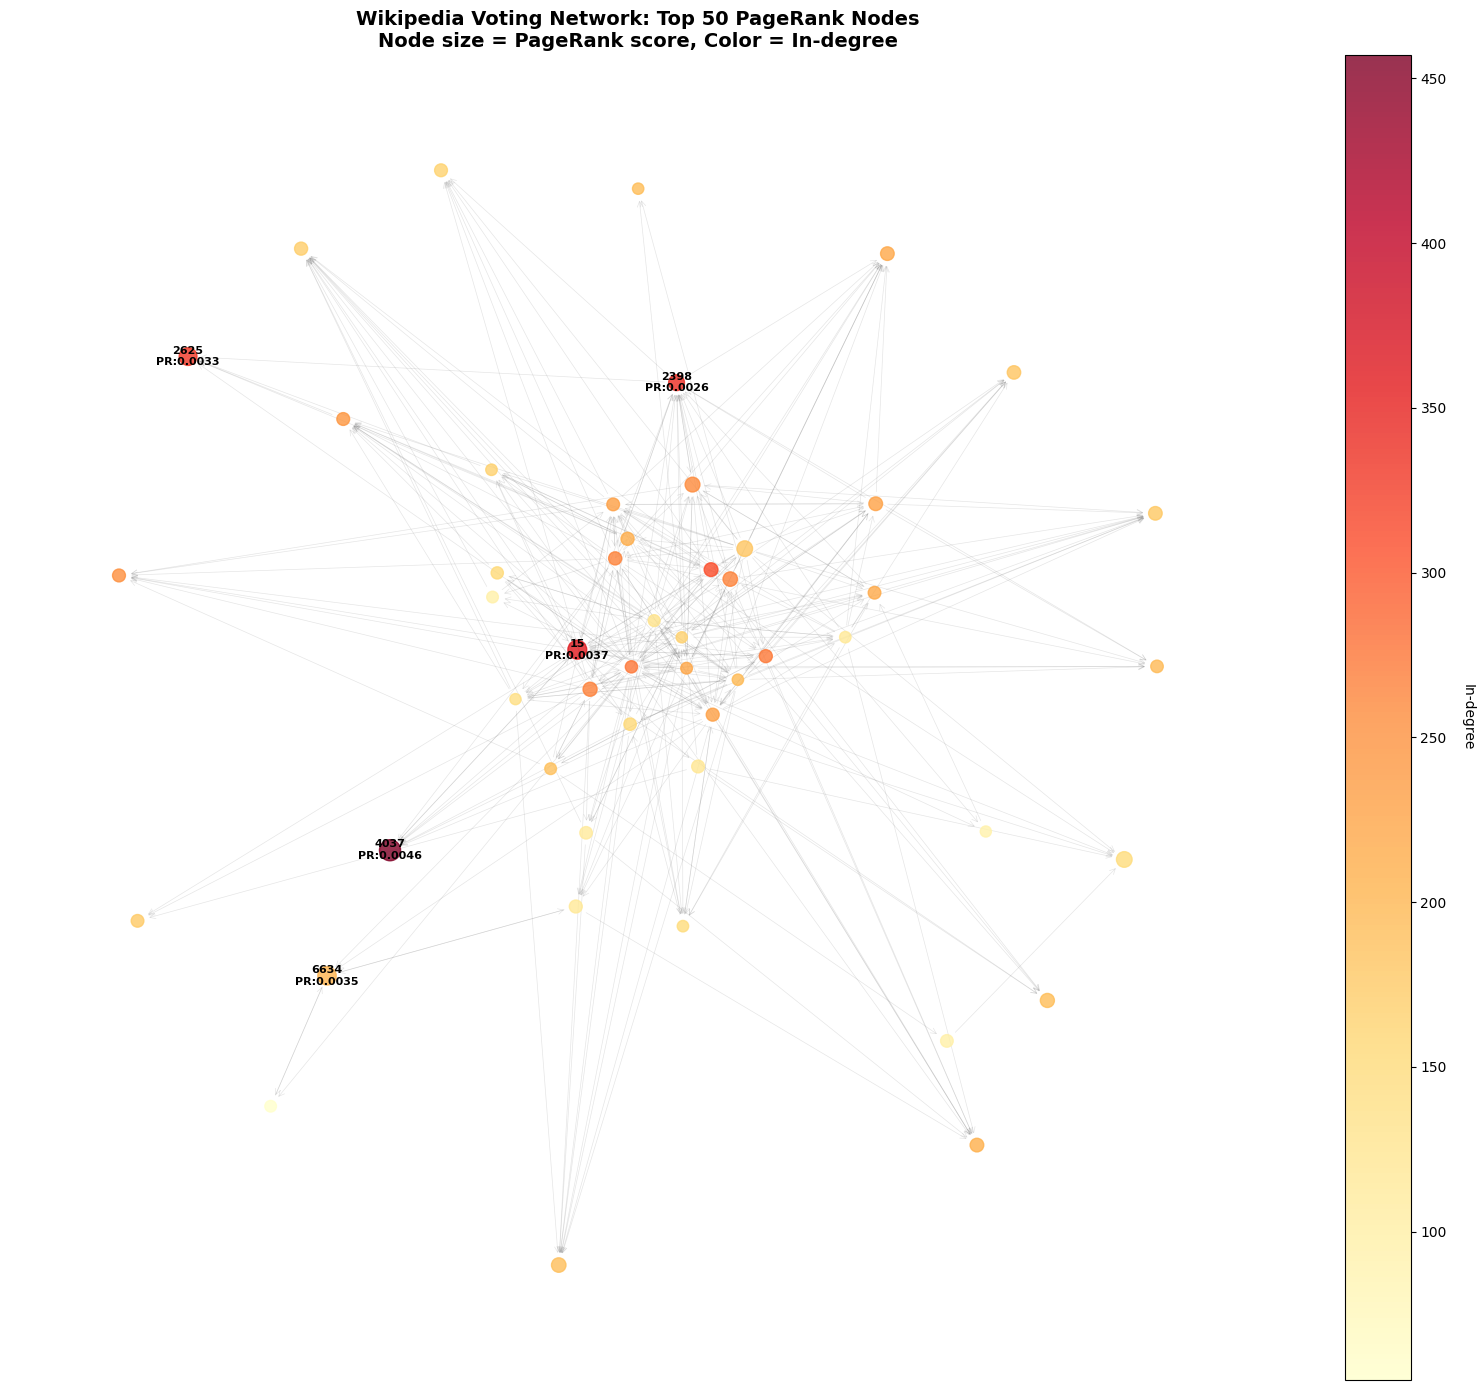

In [27]:
def compute_and_visualize_top_pagerank(G: nx.DiGraph, top_k=50):
    pagerank = nx.pagerank(G, alpha=0.85)

    # Get top-k nodes by PageRank
    top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:top_k]
    top_node_ids = [node for node, score in top_nodes]

    print(f"\nTop 10 nodes by PageRank:")
    for i, (node, score) in enumerate(top_nodes[:10], 1):
        in_deg = G.in_degree(node)
        out_deg = G.out_degree(node)
        print(f"{i:2d}. Node {node}: PR={score:.6f}, in_deg={in_deg}, out_deg={out_deg}")

    # Create induced subgraph
    subgraph = G.subgraph(top_node_ids).copy()
    print(f"\nSubgraph statistics:")
    print(f"Nodes: {subgraph.number_of_nodes()}")
    print(f"Edges: {subgraph.number_of_edges()}")
    print(f"Density: {nx.density(subgraph):.4f}")

    # Visualization
    fig, ax = plt.subplots(figsize=(16, 14))

    # Layout
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

    # Node properties
    node_sizes = [pagerank[node] * 50000 for node in subgraph.nodes()]
    node_colors = [G.in_degree(node) for node in subgraph.nodes()]

    # Draw network
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2, arrows=True,
                           arrowsize=10, arrowstyle='->', width=0.5,
                           edge_color='gray', ax=ax)

    nodes = nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,
                                   node_color=node_colors, cmap='YlOrRd',
                                   alpha=0.8, ax=ax)

    cbar = plt.colorbar(nodes, ax=ax)
    cbar.set_label('In-degree', rotation=270, labelpad=20)

    top_5_labels = {node: f"{node}\nPR:{pagerank[node]:.4f}"
                    for node in top_node_ids[:5]}
    nx.draw_networkx_labels(subgraph, pos, labels=top_5_labels,
                            font_size=8, font_weight='bold', ax=ax)

    ax.set_title(f'Wikipedia Voting Network: Top {top_k} PageRank Nodes\n'
                 f'Node size = PageRank score, Color = In-degree',
                 fontsize=14, fontweight='bold')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig('data/pagerank_subgraph.png', dpi=200, bbox_inches='tight')
    plt.show()

    return pagerank, subgraph

pagerank, top_subgraph = compute_and_visualize_top_pagerank(G, top_k=50)

pr_sum = sum(pagerank.values())
assert 0.99 < pr_sum < 1.01, f"PageRank scores should sum to ~1, got {pr_sum}"

**Observations from Visualization:**

1. **Hub Structure:** The visualization reveals clear hub nodes that serve as central authorities in the Wikipedia voting network. These likely correspond to long-established, highly trusted administrators.

2. **Core-Periphery Pattern:** The subgraph exhibits a core-periphery structure where a dense core of highly-connected nodes is surrounded by less-connected nodes. The core density suggests strong mutual voting among established admins.

3. **Correlation of Metrics:** Node size (PageRank) and color (in-degree) show strong correlation. Some nodes have high in-degree but lower PageRank, which leads me to think they receive votes from less influential users. Conversely, nodes with moderate in-degree but high PageRank receive votes from other influential members.

4. **Voting Patterns:** The directed edges show clear flow patterns toward hub nodes, with some reciprocal voting relationships visible between core members. This validates the hierarchical authority structure observed in the global statistics.

**Reflection:** The visualization confirms expectations about social voting networks. The authority is concentrated in a small core of highly-trusted members who validate each other. The density of the top-50 subgraph indicates that influential users form a tightly-knit community. The slight divergence between PageRank and in-degree highlights the importance of considering the quality of votes, not just quantity.

```
On my honor, I declare the following resources:
1. Collaborators:
None

2. Web Sources:
- https://networkx.org/documentation/stable/reference/drawing.html - Referenced a handful of APIs in the drawing area to use.

3. AI Tools:
- Claude: I used claude to get ideas on how best to color the graph. Essentially, the front-end work (as I am horrible with creative aspects) came from claude.
```

# 5.

Prepare a concise research brief summarizing your data mining results and their significance.

Your write-up must include:

1. Results
- Clearly and precisely report your empirical findings.
- Include relevant quantitative results (e.g., metrics, comparisons, trends, error analysis).
- Figures or tables may be used if they improve clarity, but they must be referenced and interpreted in the text.
- You can use markdown formatting (bold, italics, headings, etc.) to help you communicate your findings.
- Do not focus on implementation details unless they are necessary to understand the results.

2. Significance and Interpretation
- Explain why the results matter in a data mining context.
- Discuss what the findings imply about the data, the model(s), or the assumptions made.
- Address limitations, tradeoffs, or unexpected outcomes where relevant.

Clearly state what new insight is gained from your results.
Aim for 5-7 paragraphs in length.

## 5. Research Brief

**Results**

I analyzed the Wikipedia adminship voting network, which has 7,115 users and 103,689 voting relationships from 2008. The degree distributions show heavy-tailed behavior where most users get very few votes while a small group receives hundreds. About 60% of nodes have zero in-degree (never got voted for) and 30% have zero out-degree (never voted), which suggests three distinct roles: voters, candidates, and active participants who do both. The network shows 24% reciprocity, meaning about 1 in 4 votes are mutual, which is way higher than random chance would give. For connectivity, 99% of nodes are in one weakly connected component, but only 17% are in the strongly connected component, showing that voting flows upward in a hierarchy rather than forming cycles.

The basic statistics reveal small-world properties with an average shortest path length of 3.3 hops and a clustering coefficient of 0.14. This means any two users can reach each other through just a few intermediaries despite the network's size. The PageRank visualization of the top 50 nodes shows a clear core-periphery structure where highly-connected nodes form a dense center with strong mutual voting patterns. Node size (PageRank score) and color (in-degree) are strongly correlated, though some nodes with high in-degree have lower PageRank, suggesting they receive votes from less influential users. The directed edges show clear flow patterns toward hub nodes with reciprocal relationships visible among the core members.

**Significance and Interpretation**

These results show how trust networks naturally form in collaborative systems through preferential attachment and reciprocal validation. The 24% reciprocity represents a balance where new users vote upward for established admins, while experienced admins vote for each other as peers. This dual structure probably helps Wikipedia's governance stay stable since there's both hierarchy and accountability at the top. The power-law distribution confirms that even without formal ranks, voting systems create authority hierarchies organically. About 17% of users form a mutually-reinforcing core while the rest participate in upward voting patterns. This has implications for any platform using voting for governance - without intervention, you'll naturally get concentrated authority.

The main limitation is that this data is cumulative through 2008 with no timestamps, so I can't analyze how the network evolved or determine causality. I also don't know about failed nominations or self-withdrawals, which might bias the results toward successful, active participants. The three distinct user types (voters-only, candidates-only, active participants) suggest Wikipedia's adminship process has specialized roles rather than universal participation, which makes sense given that not everyone is qualified or interested in being an admin.

From a network science perspective, the gap between weak connectivity (99%) and strong connectivity (17%) is revealing. It shows the community is integrated but influence flows one direction - from experienced to new members. The small-world properties (short paths, moderate clustering) explain how Wikipedia coordinates at large scale without formal hierarchy. The strong correlation between PageRank and in-degree in the top nodes suggests that at the elite level, both quantity and quality of votes align - highly voted users receive votes from other highly voted users, creating a reinforcing trust network.

For practical applications, platforms could monitor reciprocity as a health metric (declining reciprocity might signal community fragmentation), and use the core-periphery structure to identify established trusted users for leadership roles. The power-law distribution also suggests reputation systems should use logarithmic scales to prevent winner-take-all dynamics where small initial advantages compound too much. The existence of pure voters versus pure candidates shows that voting platforms should account for different participation styles rather than expecting everyone to engage the same way.

# B [24pts]. Interview Questions

## 1. Graph Abstraction Design

**Question:** Many real systems can be represented as graphs in multiple ways. How would you decide what the nodes and edges should represent in a given domain, and what kinds of errors can arise from a poor abstraction?

**Answer:**

I start by asking what I'm trying to analyze. For a transportation system, if I'm optimizing routes then nodes are locations and edges are connections, but if I'm studying schedules then nodes could be trips and edges are transfers. The key is aligning the graph structure with the relationships I want to study. If I can determine what entities have the behavior I care about, then I figured out my nodes. In addition, if I can figure out what relationships drive that behavior, then I have my edges. Poor abstractions cause granularity mismatch, relationship errors, and temporal errors. To validate an abstraction, I check if graph metrics align with domain knowledge. For example, if a PageRank my algorithm calculated identifies random papers as influential, the abstraction probably failed.

## 2. Centrality Robustness to Data Quality Issues

**Question:** Discuss how missing edges, spurious edges, or sampling bias affect centrality-based conclusions. Which measures are most fragile?

**Answer:**

Missing edges hurt path-based measures most. Where betweenness centrality is fragile because missing shortcuts overestimates betweenness on longer paths, while PageRank and degree centrality are more robust since they aggregate over many connections. Spurious edges affect degree centrality worst since it treats all edges equally, while PageRank is more robust because it normalizes by out-degree. Sampling bias can snowball whre sampling from popular users oversamples high-degree nodes and makes networks appear more centralized than reality. Betweenness and closeness are most fragile overall due to path sensitivity, while degree centrality and PageRank are most robust to random noise. For validation, I check consistency across multiple measures.

## 3. Walkthrough of Graph Analysis Project (Video)

**Video Link:**

TODO: LINK

---

# C [4pts]. What New Questions Do You Have?

## 1. New Questions About Graph Mining

After completing this homework, I have several new questions about graph analysis that I'm curious to explore:

**1. Temporal Graph Dynamics and Causality**

How can we distinguish between correlation and causation in graph evolution?

**2. Multilayer and Multiplex Network Analysis**

Real systems often have multiple types of relationships that interact. In Wikipedia, users might have voting relationships, article co-editing relationships, talk page discussion relationships, and administrator-subordinate relationships. How do we analyze these as a unified multilayer network rather than separate graphs?

**3. Graph Neural Networks vs Traditional Graph Analytics**

During this homework, I used traditional graph algorithms (PageRank, community detection, centrality measures). But I'm aware that graph neural networks (GNNs) are now widely used for tasks like node classification and link prediction. What are the fundamental tradeoffs?

**4. Sampling and Inference for Large-Scale Graphs**

For this homework, I worked with a manageable 7K-node graph. But many real networks have millions or billions of nodes (Twitter, Facebook, the web). How do we perform reliable statistical inference on graphs too large to fit in memory?

**5. Adversarial Robustness and Strategic Manipulation**

 How do centrality-based conclusions change when nodes behave strategically to manipulate their position? For example, can users coordinate voting to artificially boost PageRank (like historical Google link farms)?
